In [1]:
import sys
from time import process_time
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import corner

ModuleNotFoundError: No module named 'emcee'

0.13487509965083333


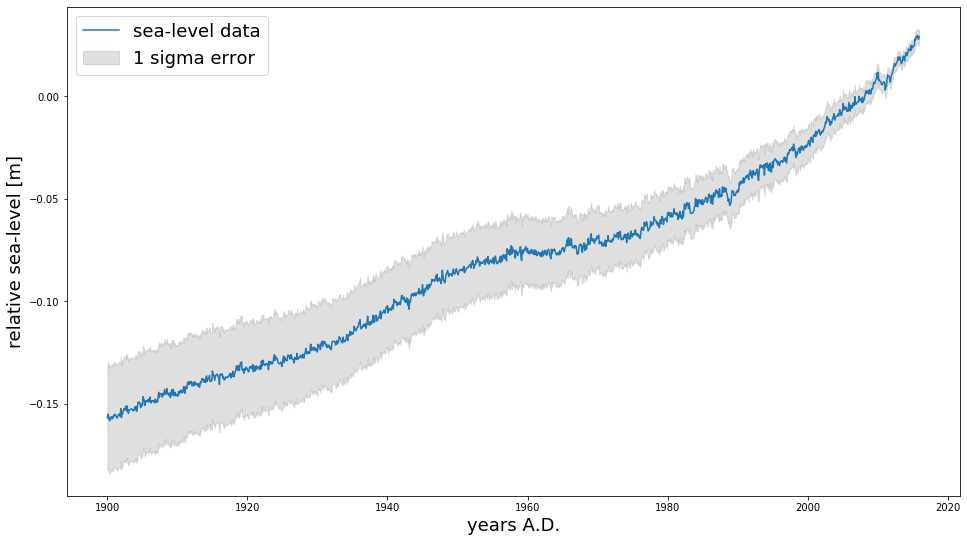

In [89]:
paleoforcing = np.loadtxt('paleoforcing.txt', dtype=float)
radforcing_past = np.zeros((paleoforcing.shape[0], 2))
radforcing_past[:, 0] = paleoforcing[:, 0]
radforcing_past[:, 1] = paleoforcing[:, 1] + np.sum(paleoforcing[:, 2:4], axis=1)/2 + np.sum(paleoforcing[:, 4:10], axis=1)/5 + paleoforcing[:, 10]   
#greenhouse, volcanic, solar, landuse
radforcing_85 = np.loadtxt('radforcing85.txt', dtype=float)        #years, total F, volcanic F, anthro F, GHG, CO2
radforcing_6 = np.loadtxt('radforcing6.txt', dtype=float)
radforcing_45 = np.loadtxt('radforcing45.txt', dtype=float)
radforcing_3 = np.loadtxt('radforcing3.txt', dtype=float)
years = 107
Forcing_wovoc = radforcing_85[:years, 1]-radforcing_85[:years, 2]
Forcing_woanthro = radforcing_85[:years, 1]-radforcing_85[:years, 3]
Forcing_onlyanthro = radforcing_85[:years, 3]
Forcing_85 = radforcing_85[:years, 1]

sealevels_amsterdam = np.loadtxt('sealevel_amsterdam.txt', dtype=float)
sealevels_liverpool = np.loadtxt('sealevel_liverpool.txt', dtype=float)
sealevels_brest = np.loadtxt('sealevel_brest.txt', dtype=float)
sealevels = np.loadtxt('sealevels.txt', dtype=float)
sealevels1 = sealevels/1000
upper = sealevels1[:, 1] + sealevels1[:, 2]
lower = sealevels1[:, 1] - sealevels1[:, 2]
fig=plt.figure(figsize=(16,9))
plt.plot(sealevels[:, 0], sealevels1[:, 1], label='sea-level data')
plt.fill_between(sealevels[:, 0], upper, lower, alpha=0.25, color='gray', label='1 sigma error')
plt.legend(loc=2, fontsize=18)
plt.xlabel('years A.D.', fontsize=18)
plt.ylabel('relative sea-level [m]', fontsize=18)
fig.savefig('sealeveldata.png', bbox_inches='tight', dpi=250)

S_dat = np.zeros(years)
S_err = np.zeros(years)
i = 0
for k in range(len(S_dat)):
    avg_sealevel = 0
    avg_error = 0
    for j in range(12):
        avg_sealevel += sealevels[i+j, 1]
        avg_error += sealevels[i+j, 2]
    S_dat[k] = avg_sealevel/12
    S_err[k] = avg_error/12
    i += 12
S_dat = S_dat/1000
print(S_dat[100] - S_dat[0])
S_err = S_err/1000
sealevels_amsterdam[:, 1] = sealevels_amsterdam[:, 1]/1000
sealevels_amsterdam[:, 1] = sealevels_amsterdam[:, 1] - (abs(S_dat[0])-abs(sealevels_amsterdam[np.where(sealevels_amsterdam[:, 0]==1900), 1]))
S_dat_amsterdam = sealevels_amsterdam[:, 1]
sealevels_liverpool[:, 1] = sealevels_liverpool[:, 1]/100
sealevels_liverpool[:, 1] = sealevels_liverpool[:, 1] + (S_dat[0]-sealevels_liverpool[np.where(sealevels_liverpool[:, 0]==1900), 1])
S_dat_liverpool = sealevels_liverpool[:, 1]
sealevels_brest[:, 1] = sealevels_brest[:, 1]/100
sealevels_brest[:, 1] = sealevels_brest[:, 1] - (abs(S_dat[0])-abs(sealevels_brest[np.where(sealevels_brest[:, 0]==1900), 1]))
S_dat_brest = sealevels_brest[:, 1]

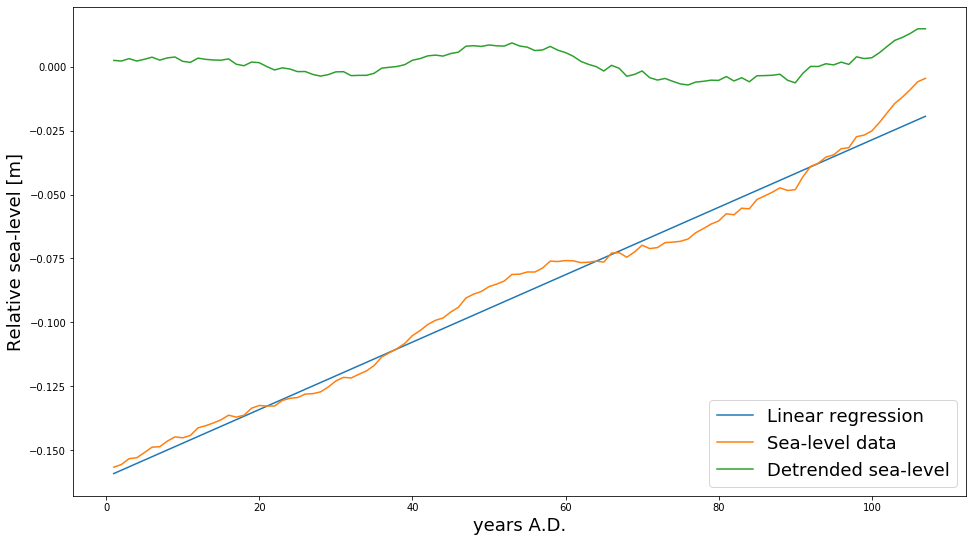

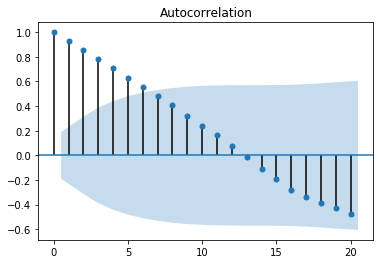

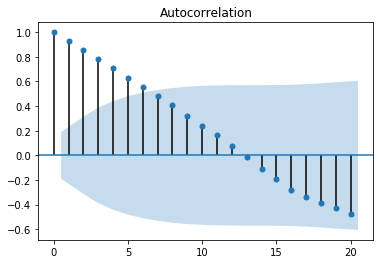

In [90]:
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

x = np.linspace(1, len(S_dat), len(S_dat))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,S_dat)
S_linreg = np.zeros(len(S_dat))
for i in range(years):
    S_linreg[i] = slope * i + intercept
S_detrend = S_dat - S_linreg   
fig=plt.figure(figsize=(16,9))
plt.plot(x, S_linreg, label='Linear regression')
plt.plot(x, S_dat, label='Sea-level data')
plt.plot(x, S_detrend, label='Detrended sea-level')
plt.xlabel('years A.D.', fontsize=18)
plt.ylabel('Relative sea-level [m]', fontsize=18)
plt.legend(loc=4, fontsize=18)
plt.show()
fig.savefig("linearregression.png", bbox_inches='tight', dpi=600)
plot_acf(S_detrend, lags=20)
fig1.savefig("autocorrelation.png", bbox_inches='tight', dpi=600)

### Model function:

In [4]:
def model(theta, Forcing, S0):
    a, b, tau = theta
    S = np.zeros(len(Forcing))
    S[0] = S0
    for t in range(1, len(Forcing)):
        S[t] = S[t-1] + ((a * Forcing[t-1] + b) - S[t-1])/tau
    return S

### Likeness function:

In [5]:
def lnlike(theta):
    S = model(theta, Forcing_85, S_dat[0])                          # change Forcing here!! and S0
    like = ((S_dat - S)/S_err) ** 2
    return -1/2 * np.sum(like) * (1/13)

### Prior function:

In [6]:
def lnprior(theta):
    a, b, tau = theta
    #a, b = theta
    a_min, a_max = -1, 3
    b_min, b_max = -3, 1
    tau_min, tau_max = 10, 120
    if a_min < a < a_max and b_min < b < b_max and tau_min < tau < tau_max:
        return 0.0
    return -np.inf

### Probability function:

In [7]:
def lnprob(theta, F, S, Serr):
    prob = lnprior(theta)
    if prob != 0.0:
        return -np.inf
    return prob + lnlike(theta)

## emcee:

In [63]:
start_time_total = process_time()
nwalkers = 1000
data = (Forcing_85, S_dat, S_err)                        # change Forcing here!!
initial = np.array([0.145, -0.124, 60])
ndim = len(initial)
niter = 1500
p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] # * np.random.randn(ndim)
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production....")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state
#theta_max_multiple = np.zeros((10, 3))
#for i in range(10):
#    start_time = process_time()
#    nwalkers = 1000
#    p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)
#    samples = sampler.flatchain
#    theta_max_multiple[i, :] = samples[np.argmax(sampler.flatlnprobability)]
#    end_time = process_time()
#    print("Elapsed Time:", (end_time - start_time)/60)

print("finished")
end_time_total = process_time()
print("Elapsed Time:", (end_time_total - start_time_total)/60)

Running burn-in...
Running production....
finished
Elapsed Time: 9.257145533333338


### emcee results:

[ 0.14537472 -0.12516198 62.6014338 ]
0.23435895395395048
20th century SLR:  0.13485054030173044 m.


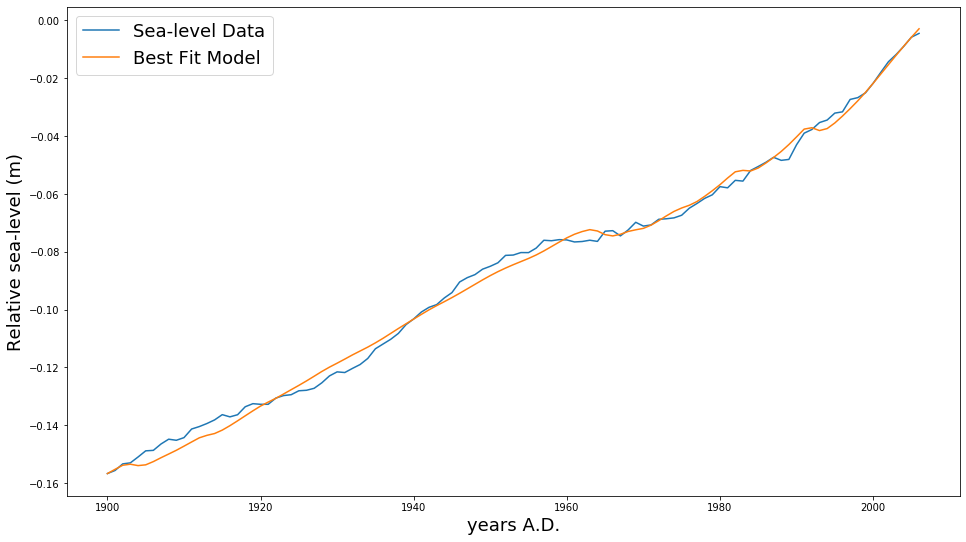

In [64]:
t = np.linspace(1900, 2006, 107)
samples = sampler.flatchain
theta_max= samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max, Forcing_85, S_dat[0])                              #change forcing here!!
error = S_dat - best_fit_model
total_error = np.sum(abs(error))
print("best fit parameters: ", theta_max)
print(total_error)
SLR_20 = best_fit_model[-7] - best_fit_model[0]
print("20th century SLR: ", SLR_20, "m.")

fig=plt.figure(figsize=(16,9))
plt.plot(t, S_dat, label='Sea-level Data')
plt.plot(t, best_fit_model, label='Best Fit Model')
plt.legend(loc=2, fontsize=18)
plt.xlabel('years A.D.', fontsize=18)
plt.ylabel('Relative sea-level (m)', fontsize=18)
plt.show()
fig.savefig('emceeresult.png', bbox_inches='tight', dpi=250)

### Parameter space exploration plot:

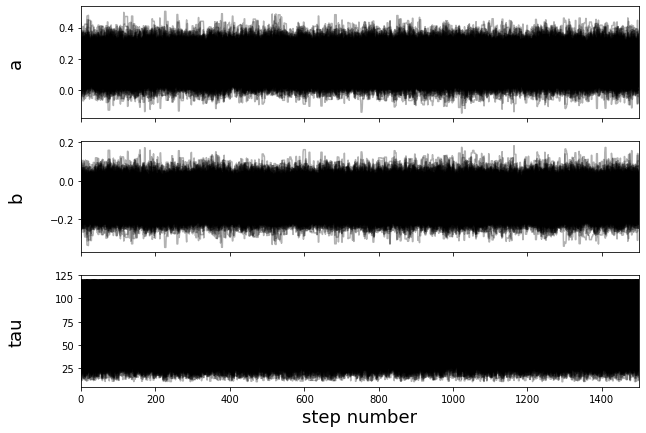

In [87]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples_plot = sampler.get_chain()
labels = ["a", "b", "tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_plot[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_plot))
    ax.set_ylabel(labels[i], fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number", fontsize=18);
fig.savefig('exploration.png', bbox_inches='tight', dpi=250)

### Corner Plots:

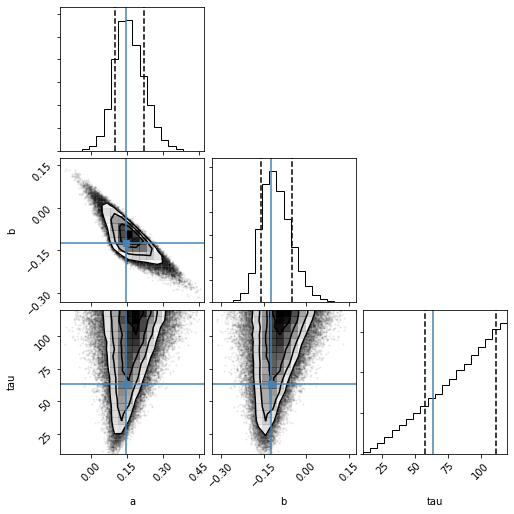

In [160]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[theta_max[0], theta_max[1], theta_max[2]], quantiles=(0.16, 0.84)
);

## For multiple runs:

[[ 0.1443927  -0.12523455 61.99732407]
 [ 0.14629474 -0.12343628 64.41716019]
 [ 0.14601088 -0.12368295 64.0576846 ]
 [ 0.14442935 -0.12517732 62.06164957]
 [ 0.14496879 -0.12461346 62.74428945]
 [ 0.14537135 -0.12482961 62.8282024 ]
 [ 0.14669732 -0.1239245  64.35129555]
 [ 0.14523953 -0.12533023 62.39698852]
 [ 0.14539989 -0.12456726 63.08348673]
 [ 0.14602055 -0.12331855 64.39164791]]
[7.12192125e-06 7.15897558e-06 7.15018155e-06 7.12193963e-06
 7.12724570e-06 7.13991051e-06 7.18327078e-06 7.14265198e-06
 7.13910430e-06 7.15061958e-06]


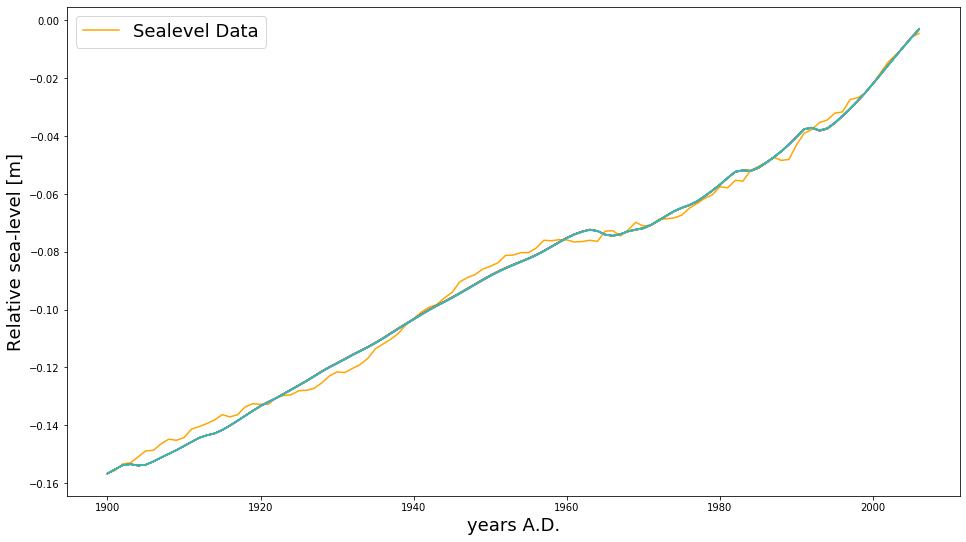

In [91]:
runs=10
#print(theta_max_multiple)
t = np.linspace(1900, 1900+years-1, years)
best_fit_models = np.zeros((years, runs))
total_error = np.zeros(runs)
for i in range(runs):
    best_fit_models[:, i] = model(theta_max_multiple[i, :], Forcing_85, S_dat[0])
    total_error[i] = 1/years*np.sum((S_dat-best_fit_models[:, i])**2)
#print(total_error)
fig=plt.figure(figsize=(16,9))
plt.plot(t, S_dat, label='Sealevel Data', color='orange')
for i in range(runs):
    plt.plot(t, best_fit_models[:, i])
plt.xlabel('years A.D.', fontsize=18)
plt.ylabel('Relative sea-level [m]', fontsize=18)
plt.legend(loc=2, fontsize=18)
plt.show()
fig.savefig('differentresults.png', bbox_inches='tight', dpi=250)

## For 1 run with spread:

<Figure size 1152x648 with 0 Axes>

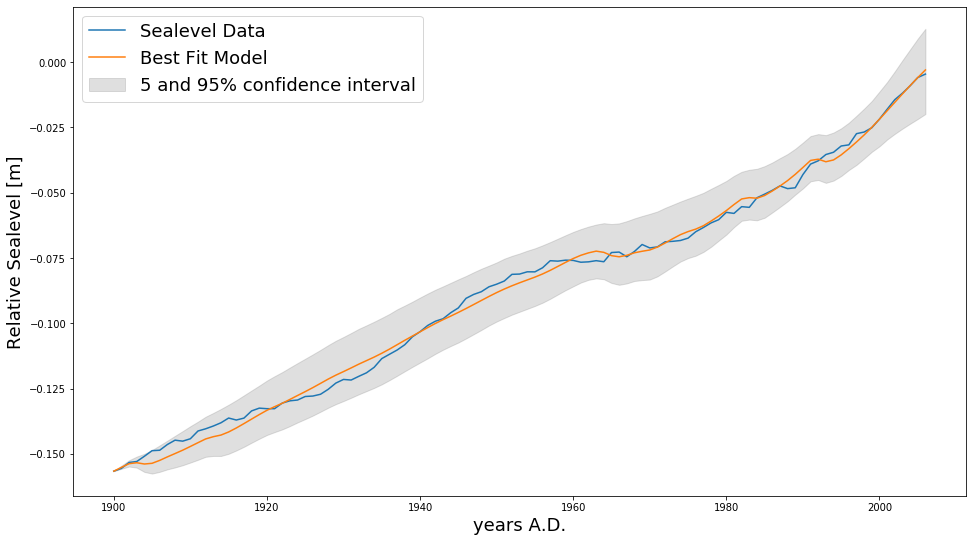

In [92]:
all_tries = samples.shape[0]
models = np.zeros((len(t), nwalkers))
fig=plt.figure(figsize=(16,9))
for i in range(nwalkers):
    models[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_85, S_dat[0])        # int(np.random.rand(1)*all_tries)
    #plt.plot(t, models[:, i])
#plt.xlabel('years A.D.')
#plt.ylabel('Relative sea-level (m)')
#plt.show()
lower = np.percentile(models, 5, axis=1)
upper = np.percentile(models, 95, axis=1)
#fig.savefig("emcee_with_factor.png", bbox_inches='tight', dpi=250)
boundary = np.zeros((len(t), 2))
boundary[:, 0] = lower
boundary[:, 1] = upper

fig=plt.figure(figsize=(16,9))
plt.fill_between(t, boundary[:, 1], boundary[:, 0], alpha=0.25, color='gray', label='5 and 95% confidence interval')
plt.plot(t, S_dat, label='Sealevel Data')
plt.plot(t, best_fit_model, label='Best Fit Model')
plt.legend(loc=2, fontsize=18)
plt.xlabel('years A.D.', fontsize=18)
plt.ylabel('Relative Sealevel [m]', fontsize=18)
plt.show()
fig.savefig("emceeresult.png", bbox_inches='tight', dpi=250)

### Future predictions 2100, 2500 with RCP starting 1900:

1.6827985275267006
Boundary values sea-level future: [0.7383355  3.08371278]
0.7635647054181358
Boundary values sea-level future: [0.35226693 1.44255644]
0.5053409784813094
Boundary values sea-level future: [0.23715984 0.97039117]
0.07600099413096285
Boundary values sea-level future: [0.01872722 0.2216413 ]
0.5614949449696692
Boundary values sea-level future: [0.21471037 0.82326123]
0.38614905795816773
Boundary values sea-level future: [0.15905582 0.57436192]
0.3441471132219069
Boundary values sea-level future: [0.14535952 0.51890142]
0.22564661982651385
Boundary values sea-level future: [0.10329775 0.356408  ]


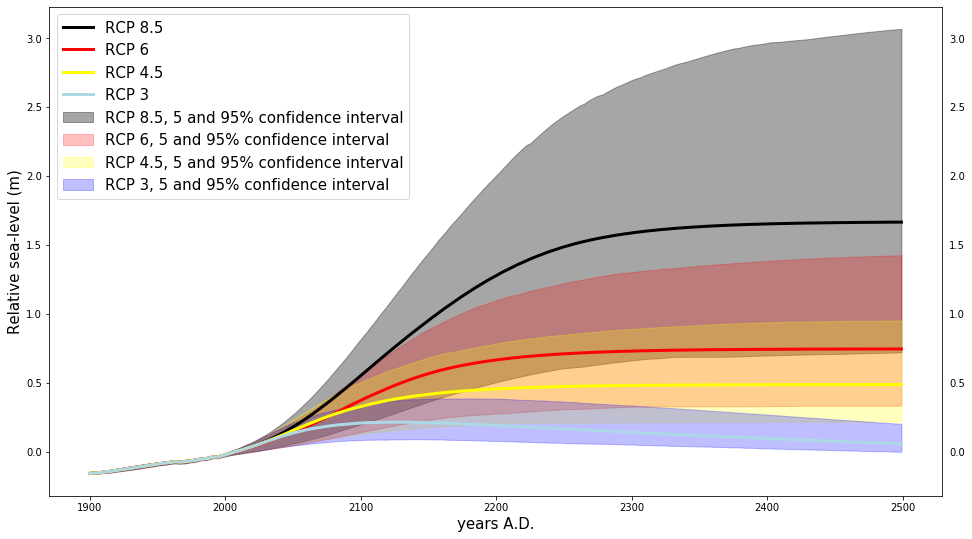

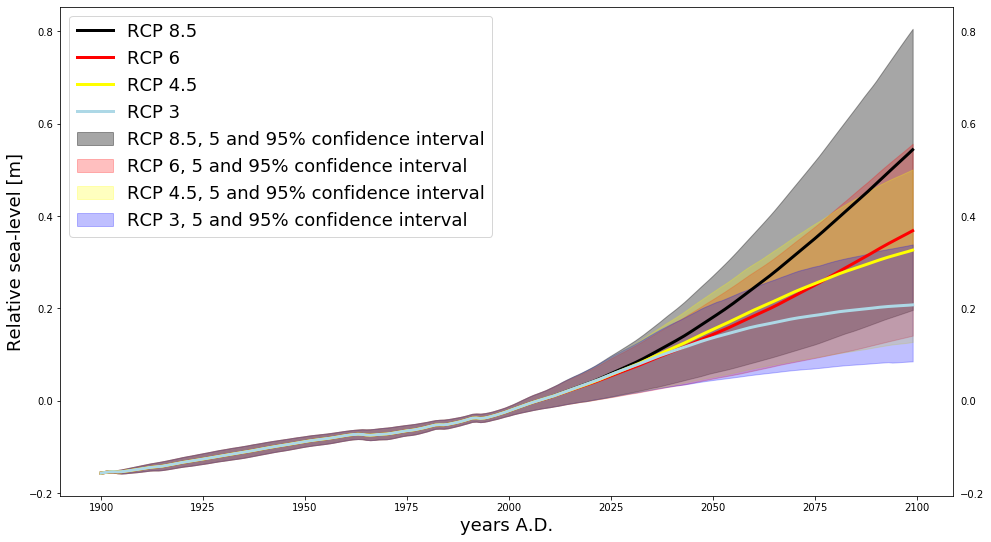

In [93]:
year = 2499
years_future = int(year + 1 - 1900)
all_tries = samples.shape[0]

Forcing_future85 = radforcing_85[:years_future, 1]
S_future85 = model(theta_max, Forcing_future85, S_dat[0])
print(S_future85[-1] - S_dat[101])
models_future85 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future85[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future85, S_dat[0])
boundary_future85 = np.zeros((years_future, 2))
boundary_future85[:, 0] = np.percentile(models_future85, 5, axis=1)
boundary_future85[:, 1] = np.percentile(models_future85, 95, axis=1)
print("Boundary values sea-level future:", boundary_future85[-1, :] - S_dat[101])

Forcing_future6 = radforcing_6[:years_future, 1]
S_future6 = model(theta_max, Forcing_future6, S_dat[0])
print(S_future6[-1] - S_dat[101])
models_future6 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future6[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future6, S_dat[0])
boundary_future6 = np.zeros((years_future, 2))
boundary_future6[:, 0] = np.percentile(models_future6, 5, axis=1)
boundary_future6[:, 1] = np.percentile(models_future6, 95, axis=1)
print("Boundary values sea-level future:", boundary_future6[-1, :] - S_dat[101])

Forcing_future45 = radforcing_45[:years_future, 1]
S_future45 = model(theta_max, Forcing_future45, S_dat[0])
print(S_future45[-1] - S_dat[101])
models_future45 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future45[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future45, S_dat[0])
boundary_future45 = np.zeros((years_future, 2))
boundary_future45[:, 0] = np.percentile(models_future45, 5, axis=1)
boundary_future45[:, 1] = np.percentile(models_future45, 95, axis=1)
print("Boundary values sea-level future:", boundary_future45[-1, :] - S_dat[101])

Forcing_future3 = radforcing_3[:years_future, 1]
S_future3 = model(theta_max, Forcing_future3, S_dat[0])
print(S_future3[-1] - S_dat[101])
models_future3 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future3[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future3, S_dat[0])
boundary_future3 = np.zeros((years_future, 2))
boundary_future3[:, 0] = np.percentile(models_future3, 5, axis=1)
boundary_future3[:, 1] = np.percentile(models_future3, 95, axis=1)
print("Boundary values sea-level future:", boundary_future3[-1, :] - S_dat[101])

t = np.linspace(1900, 2005, 107)
t_future = np.linspace(1900, year, years_future)
fig= plt.figure(figsize=(16,9))
plt.plot(t_future, S_future85, label='RCP 8.5', color='black', linewidth=3)
plt.fill_between(t_future, boundary_future85[:, 1], boundary_future85[:, 0], alpha=0.35, color='black', label='RCP 8.5, 5 and 95% confidence interval')
plt.plot(t_future, S_future6, label='RCP 6', color='red', linewidth=3)
plt.fill_between(t_future, boundary_future6[:, 1], boundary_future6[:, 0], alpha=0.25, color='red', label='RCP 6, 5 and 95% confidence interval')
plt.plot(t_future, S_future45, label='RCP 4.5', color='yellow', linewidth=3)
plt.fill_between(t_future, boundary_future45[:, 1], boundary_future45[:, 0], alpha=0.25, color='yellow', label='RCP 4.5, 5 and 95% confidence interval')
plt.plot(t_future, S_future3, label='RCP 3', color='lightblue', linewidth=3)
plt.fill_between(t_future, boundary_future3[:, 1], boundary_future3[:, 0], alpha=0.25, color='blue', label='RCP 3, 5 and 95% confidence interval')
plt.legend(loc=2, fontsize=15)
plt.xlabel('years A.D.', fontsize=15)
plt.tick_params(labelright=True)
plt.ylabel('Relative sea-level (m)', fontsize=15)
#plt.show()
year = 2099
years_future = int(year + 1 - 1900)

Forcing_future85 = radforcing_85[:years_future, 1]
S_future85 = model(theta_max, Forcing_future85, S_dat[0])
print(S_future85[-1] - S_dat[101])
models_future85 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future85[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future85, S_dat[0])
boundary_future85 = np.zeros((years_future, 2))
boundary_future85[:, 0] = np.percentile(models_future85, 5, axis=1)
boundary_future85[:, 1] = np.percentile(models_future85, 95, axis=1)
print("Boundary values sea-level future:", boundary_future85[-1, :] - S_dat[101])

Forcing_future6 = radforcing_6[:years_future, 1]
S_future6 = model(theta_max, Forcing_future6, S_dat[0])
print(S_future6[-1] - S_dat[101])
models_future6 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future6[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future6, S_dat[0])
boundary_future6 = np.zeros((years_future, 2))
boundary_future6[:, 0] = np.percentile(models_future6, 5, axis=1)
boundary_future6[:, 1] = np.percentile(models_future6, 95, axis=1)
print("Boundary values sea-level future:", boundary_future6[-1, :] - S_dat[101])

Forcing_future45 = radforcing_45[:years_future, 1]
S_future45 = model(theta_max, Forcing_future45, S_dat[0])
print(S_future45[-1] - S_dat[101])
models_future45 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future45[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future45, S_dat[0])
boundary_future45 = np.zeros((years_future, 2))
boundary_future45[:, 0] = np.percentile(models_future45, 5, axis=1)
boundary_future45[:, 1] = np.percentile(models_future45, 95, axis=1)
print("Boundary values sea-level future:", boundary_future45[-1, :] - S_dat[101])

Forcing_future3 = radforcing_3[:years_future, 1]
S_future3 = model(theta_max, Forcing_future3, S_dat[0])
print(S_future3[-1] - S_dat[101])
models_future3 = np.zeros((years_future, nwalkers))
for i in range(nwalkers):
    models_future3[:, i] = model(samples[nwalkers*niter-nwalkers+i], Forcing_future3, S_dat[0])
boundary_future3 = np.zeros((years_future, 2))
boundary_future3[:, 0] = np.percentile(models_future3, 5, axis=1)
boundary_future3[:, 1] = np.percentile(models_future3, 95, axis=1)
print("Boundary values sea-level future:", boundary_future3[-1, :] - S_dat[101])

t = np.linspace(1900, 2005, 107)
t_future = np.linspace(1900, year, years_future)
fig= plt.figure(figsize=(16,9))
plt.plot(t_future, S_future85, label='RCP 8.5', color='black', linewidth=3)
plt.fill_between(t_future, boundary_future85[:, 1], boundary_future85[:, 0], alpha=0.35, color='black', label='RCP 8.5, 5 and 95% confidence interval')
plt.plot(t_future, S_future6, label='RCP 6', color='red', linewidth=3)
plt.fill_between(t_future, boundary_future6[:, 1], boundary_future6[:, 0], alpha=0.25, color='red', label='RCP 6, 5 and 95% confidence interval')
plt.plot(t_future, S_future45, label='RCP 4.5', color='yellow', linewidth=3)
plt.fill_between(t_future, boundary_future45[:, 1], boundary_future45[:, 0], alpha=0.25, color='yellow', label='RCP 4.5, 5 and 95% confidence interval')
plt.plot(t_future, S_future3, label='RCP 3', color='lightblue', linewidth=3)
plt.fill_between(t_future, boundary_future3[:, 1], boundary_future3[:, 0], alpha=0.25, color='blue', label='RCP 3, 5 and 95% confidence interval')
plt.legend(loc=2, fontsize=18)
plt.xlabel('years A.D.', fontsize=18)
plt.tick_params(labelright=True)
plt.ylabel('Relative sea-level [m]', fontsize=18)
plt.show()
fig.savefig('prediction.png', bbox_inches='tight', dpi=250)

### Counterfactuals and ratio between anthropogenic/natural SLR:

Total: 0.15371031356191328
Without Anthro: 0.03609560491260211
Only Anthro: 0.1434011686374505
Ratio of SLR in 20th century due to anthropogenic forcing: 0.7180662661567
SLR in 20th century due to anthropogenic forcing: 0.09683162396367717
Ratio of SLR due to natural forcing: 0.28193373384330017
SLR in 20th century due to nautral forcing: 0.038018916338053294


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


<Figure size 216x144 with 0 Axes>

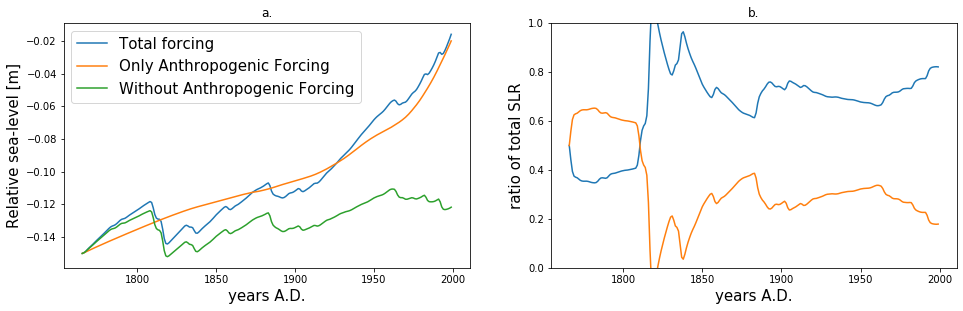

In [94]:
S_total = model(theta_max, Forcing_85, S_dat[0])
print("Total:", abs(S_total[0]-S_total[years-1]))
S_woanthro = model(theta_max, Forcing_woanthro, S_dat[0])
print("Without Anthro:", abs(S_total[0]-S_woanthro[years-1]))
S_onlyanthro = model(theta_max, Forcing_onlyanthro, S_dat[0])
print("Only Anthro:", abs(S_total[0]-S_onlyanthro[years-1]))
t = np.linspace(1900, 1900+years-1, years)
fig = plt.figure(figsize=(3,2))
year = 235
S0 = -0.15
radforcing_85_complete = np.loadtxt('rcp85_complete.txt', dtype=float)
model_85 = model(theta_max, radforcing_85_complete[:year, 1], S0)
radforcing_6_complete = np.loadtxt('rcp6_complete.txt', dtype=float)
model_6 = model(theta_max, radforcing_6_complete[:year, 1], S0)
radforcing_45_complete = np.loadtxt('rcp45_complete.txt', dtype=float)
model_45 = model(theta_max, radforcing_45_complete[:year, 1], S0)
radforcing_3_complete = np.loadtxt('rcp3_complete.txt', dtype=float)
model_3 = model(theta_max, radforcing_3_complete[:year, 1], S0)

radforcing_onlyanthro_complete = np.zeros((radforcing_85_complete.shape[0], 2))
radforcing_onlyanthro_complete[:, 0] = radforcing_85_complete[:, 0]
radforcing_onlyanthro_complete[:, 1] = radforcing_85_complete[:, 3]
model_onlyanthro = model(theta_max, radforcing_onlyanthro_complete[:year, 1], S0)

radforcing_woanthro_complete = np.zeros((radforcing_85_complete.shape[0], 2))
radforcing_woanthro_complete[:, 0] = radforcing_85_complete[:, 0]
radforcing_woanthro_complete[:, 1] = radforcing_85_complete[:, 1] - radforcing_85_complete[:, 3]
model_woanthro = model(theta_max, radforcing_woanthro_complete[:year, 1], S0)

model_complete = model_onlyanthro + model_woanthro+0.15
change_beginning = model_complete + 0.15
change_beginning_anthro = model_onlyanthro + 0.15
change_beginning_woanthro = model_woanthro + 0.15
ratio_anthro = change_beginning_anthro/change_beginning
print("Ratio of SLR in 20th century due to anthropogenic forcing:", np.average(ratio_anthro[130:230]))
print("SLR in 20th century due to anthropogenic forcing:", SLR_20*np.average(ratio_anthro[130:230]))
ratio_natural = change_beginning_woanthro/change_beginning
print("Ratio of SLR due to natural forcing:", np.average(ratio_natural[130:230]))
print("SLR in 20th century due to nautral forcing:", SLR_20*np.average(ratio_natural[130:230]))

fig = plt.figure(figsize=(16,4.5))
plt.subplot(122)
plt.plot(radforcing_85_complete[:year, 0], ratio_anthro, label='ratio SLR due to anthropogenig forcing')
plt.plot(radforcing_85_complete[:year, 0], ratio_natural, label='ratio SLR due to natural forcing')
plt.ylim((0, 1))
#plt.legend(loc=1, fontsize=15)
plt.xlabel('years A.D.', fontsize=15)
plt.ylabel('ratio of total SLR', fontsize=15)
plt.title('b.')
#fig.savefig("anthronaturalratio.png", bbox_inches='tight', dpi=250)
#factors = abs(S_total[:year]) - abs(model_complete)
plt.subplot(121)
plt.plot(radforcing_85_complete[:year, 0], model_85, label='Total forcing')
plt.plot(radforcing_onlyanthro_complete[:year, 0], model_onlyanthro, label='Only Anthropogenic Forcing')
#plt.plot(radforcing_onlyanthro_complete[:year, 0], model_complete, label='COMPLETE')
plt.plot(radforcing_woanthro_complete[:year, 0], model_woanthro, label='Without Anthropogenic Forcing')
#plt.plot(radforcing_wovolc_complete[:year, 0], model_wovolc, label='Without Volcanic Forcing')
#plt.plot(radforcing_woco2_complete[:year, 0], model_woco2, label='Without CO2 Forcing')
#plt.plot(radforcing_woghg_complete[:year, 0], model_woghg, label='Without Greenhouse gas Forcing')
plt.legend(loc=2, fontsize=15)
plt.title('a.')
plt.xlabel('years A.D.', fontsize=15)
plt.ylabel('Relative sea-level [m]', fontsize=15)
plt.show()
fig.savefig("counterfactuals.png", bbox_inches='tight', dpi=250)

### Comparison to past sea-level data:

-0.17828793596419792
-0.15050306873366256


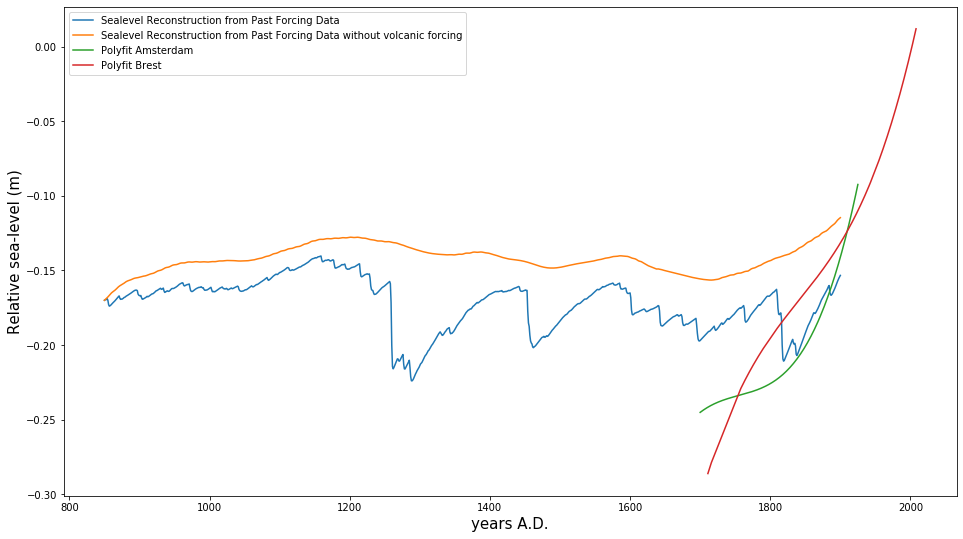

<Figure size 1152x648 with 0 Axes>

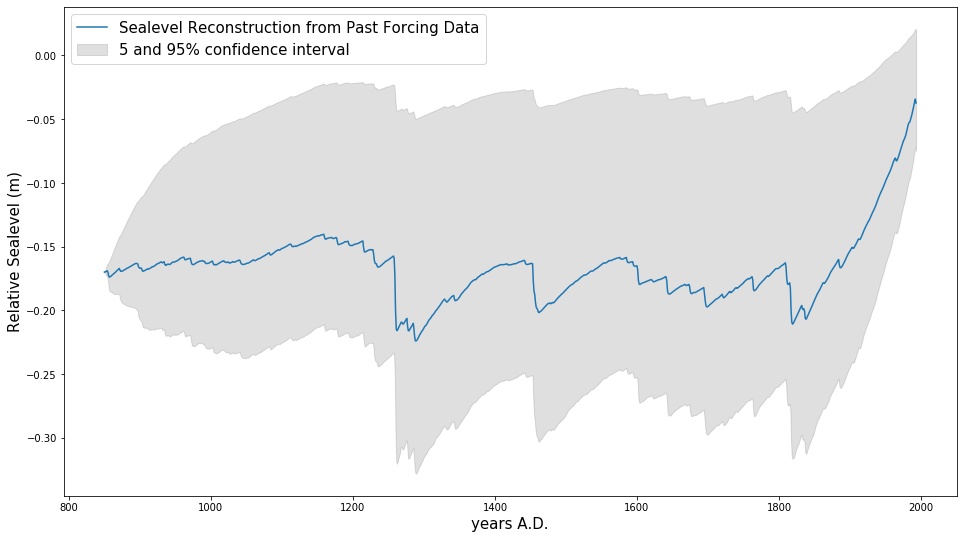

In [186]:
S_past = model(theta_max, radforcing_past[:int(1901-radforcing_past[0, 0]), 1], -0.17)
print(np.average(S_past[900:930]))
S_recent = radforcing_past[:int(1901-radforcing_past[0, 0]), 0]
fit = model(theta_max, Forcing_85, S_dat[0])
t_present = np.linspace(1900, 1900+years-1, years)

S_past_wovolc = model(theta_max, radforcing_past[:, 1]-np.sum(paleoforcing[:, 2:4], axis=1)/2, -0.17)
print(np.average(S_past_wovolc[900:930]))

p = np.polyfit(sealevels_amsterdam[:, 0], sealevels_amsterdam[:, 1], 3)
polyfit_amsterdam = p[0]*sealevels_amsterdam[:, 0]**3 + p[1]*sealevels_amsterdam[:, 0]**2 + p[2]*sealevels_amsterdam[:, 0] + p[3]
p1 = np.polyfit(sealevels_brest[:, 0], sealevels_brest[:, 1], 3)
polyfit_brest = p1[0]*sealevels_brest[:, 0]**3 + p1[1]*sealevels_brest[:, 0]**2 + p1[2]*sealevels_brest[:, 0] + p1[3]

fig= plt.figure(figsize=(16,9))
plt.plot(paleoforcing[:int(1901-radforcing_past[0, 0]), 0], S_past, label='Sealevel Reconstruction from Past Forcing Data')
plt.plot(paleoforcing[:int(1901-radforcing_past[0, 0]), 0], S_past_wovolc[:int(1901-radforcing_past[0, 0])], label='Sealevel Reconstruction from Past Forcing Data without volcanic forcing')
#plt.plot(t_present, fit, label='Sealevel Reconstruction from RCP Data')
#plt.plot(sealevels_amsterdam[:, 0], sealevels_amsterdam[:, 1])
plt.plot(sealevels_amsterdam[:, 0], polyfit_amsterdam, label='Polyfit Amsterdam')
#plt.plot(sealevels_liverpool[:, 0], sealevels_liverpool[:, 1])
#plt.plot(sealevels_brest[:, 0], sealevels_brest[:, 1], label='Sealevels Brest')
plt.plot(sealevels_brest[:, 0], polyfit_brest, label='Polyfit Brest')
plt.xlabel('years A.D.', fontsize=15)
plt.ylabel('Relative sea-level (m)', fontsize=15)
plt.legend(loc=2)
plt.show()
#fig= plt.figure(figsize=(5.7,3.7))
#plt.plot(radforcing_past[:350, 0], radforcing_past[:350, 1])
#plt.show()
#print(radforcing_past[:350, 0])


all_tries = samples.shape[0]
#models_past = np.zeros((len(radforcing_past[:int(1901-radforcing_past[0, 0]), 1]), nwalkers))
models_past = np.zeros((len(radforcing_past[:, 1]), nwalkers))
for i in range(nwalkers):
    models_past[:, i] = model(samples[nwalkers*niter-nwalkers+i], radforcing_past[:, 1], -0.17)        # int(np.random.rand(1)*all_tries)
boundary = np.zeros((len(radforcing_past[:, 1]), 2))
boundary[:, 0] = np.percentile(models_past, 5, axis=1)
boundary[:, 1] = np.percentile(models_past, 95, axis=1)
#lower = np.percentile(models_past, 5, axis=1)
#upper = np.percentile(models_past, 95, axis=1)
#boundary = np.zeros((len(radforcing_past[:int(1901-radforcing_past[0, 0]), 1]), 2))

S_past = model(theta_max, radforcing_past[:, 1], -0.17)

fig=plt.figure(figsize=(16,9))
#plt.fill_between(paleoforcing[:int(1901-radforcing_past[0, 0]), 0], boundary[:, 1], boundary[:, 0], alpha=0.25, color='gray', label='5 and 95% confidence interval')
plt.fill_between(paleoforcing[:, 0], boundary[:, 1], boundary[:, 0], alpha=0.25, color='gray', label='5 and 95% confidence interval')
#plt.plot(paleoforcing[:int(1901-radforcing_past[0, 0]), 0], S_past, label='Sealevel Reconstruction from Past Forcing Data')
plt.plot(paleoforcing[:, 0], S_past, label='Sealevel Reconstruction from Past Forcing Data')
plt.legend(loc=2, fontsize=15)
plt.xlabel('years A.D.', fontsize=15)
plt.ylabel('Relative Sealevel (m)', fontsize=15)
plt.show()
fig.savefig("pasttt.png", bbox_inches='tight', dpi=250)

# plot for comparison of a parameter:

[ 0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6
  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.
  3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4
  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8
  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2
  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6
  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10. ]


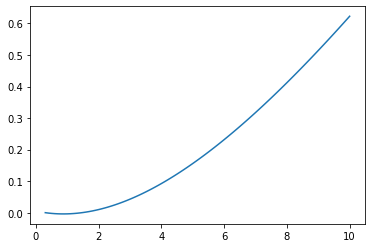

In [20]:
co2_forcing = np.linspace(0.3, 10, 98)
co2_sealevel = model(theta_max_single, co2_forcing, 0)
plt.plot(co2_forcing, co2_sealevel)